# Load packages

In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import gumbel_r
from matplotlib.pyplot import cm
import math
import matplotlib
import matplotlib.colors as mcolors
from scipy.optimize import fsolve

import sympy
from sympy import *
from sympy import symbols, Eq, solve
from shapely.geometry import LineString


%matplotlib inline
# plt.style.use('ggplot')
import warnings
from scipy.stats import pearsonr
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick


output = 'Output34'
Input = 'Input21'

colors2 = ['#6CC24A','#FFB81C', '#A50034'] # groen geel rood
colors4 = [ '#A50034', '#FFB81C', '#6CC24A'] # rood geel groen
colors = ['#0098FA', '#0167A9', '#002C48'] # blauw blauw blauw
c3 = ['#009B77', '#6CC24A', '#FFB81C', '#EC6842', '#A50034', '#6F1D77', '#EF60A3'] # groen groen geel oranjerood paarsrood paars roze
c4 = ['#6CC24A', '#FFB81C', '#EC6842', '#A50034', '#6F1D77'] # groen geel oranjerood paarsrood paars

# Catchment descriptors

In [2]:
#HAI
def HAI_calculate(temp, precipitation):

    temp_adjusted = np.zeros(12)
    
    for i in range(1,13):
        if temp[i] < 0:
            temp_adjusted[i-1] = 0
        elif temp[i] > 30:
            temp_adjusted[i-1] = 30
        else:
            temp_adjusted[i-1] = temp[i]            
        
    T = np.sum(temp_adjusted)
    HAI = (58.93 * (T/12))/precipitation
    
    return HAI


#Function for the Seasonality Index
def Seasonality_index(Annual_mean, Monthly_mean):
    SI = (1/Annual_mean) * np.sum(np.abs(Monthly_mean - (Annual_mean/12)))
    
    return SI

#Function for Seasonality Timing Index
def ST_calc(dP,dT):
    days = 366
    ST = dP[0] * np.sign(dT[0]) * np.cos((np.pi * (dP[1] - dT[1]))/days)
    return ST

#Functions to compute Seasonal variability indexes
def T_daily(dT):
    t = np.linspace(1,366,366)
    days = 366
    T = T_mean + dT[0] * np.sin((2*np.pi * (t-dT[1]))/days)
    return T

def Cal_T_daily(dT):
    days = 366
    T_calc = T_daily(dT)
    
    return (np.sum(np.abs(T_calc - T_obs)))/days

def P_daily(dP):
    t = np.linspace(1,366,366)
    days = 366
    P = P_mean * (1 + dP[0] * np.sin((2*np.pi * (t-dP[1]))/days))
    return P

def Cal_P_daily(dP):
    days = 366
    P_calc = P_daily(dP)
    
    return (np.sum(np.abs(P_calc - P_obs)))/days

def E_daily(dE):
#    t = np.linspace(1,366,366)
    t = np.linspace(1,366,366)

    days = 366
    E = E_mean * (1 + dE[0] * np.sin((2*np.pi * (t-dE[1]))/days))
    return E

def Cal_E_daily(dE):
    days = 366
    E_calc = E_daily(dE)
    
    return (np.sum(np.abs(E_calc - E_obs)))/days


#Function for the interstorm duration or low_prec_freq
def Interstorm_duration(P):
    interstorm = []
    count = 0

    for j in range(len(P)):
        if P[j] < 1:
            count += 1
        elif P[j] >= 1 and count > 0:
            interstorm.append(count)
            count = 0 
    interstorm_duration = np.mean(interstorm)
    return interstorm_duration

#Function to compute the root-zone storage capacity
def rootzone(df_out, RP):
    # firstyear = df_out['hydroyear'].iloc[0]
    # lastyear = df_out['hydroyear'].iloc[-1]
    # df_out = df_out.drop(df_out[df_out['hydroyear']==firstyear].index)
    # df_out = df_out.drop(df_out[df_out['hydroyear']==lastyear].index)
    years = df_out.groupby(['hydroyear'])
    SD = years['SD_sum'].max() - years['SD_sum'].min()
    var = gumbel_r.fit(SD)
    p = 1-1/RP
    Sr = gumbel_r.ppf(p, var[0],var[1])
    return(Sr, df_out)

#Function to compute the potential evaporation for CAMELS-USA
def calc_Makkink_knmi_USA(Temp, Rs, rho_w = 1000):
    """
    Rs in J/m2/day
    temp in degree C
    Eref in m/d
	zoals in Hiemstra en Sluiter 2011 (KNMI rapport)
    """
    Eref = np.zeros(len(Temp))
    for i in range(len(Temp)):
        gamma=0.0646+0.00006*Temp[i]                    #psychrometer constante (kPa/C)
        labda=1000*(2501-2.38*Temp[i])                  #verdampingswarmte water (J/kg)
        es=0.6107*10**((7.5*Temp[i])/(237.3+Temp[i]));              #verzadigde dampingspanning tov water (C)
        Slope=((7.5*237.3)/((237.3+Temp[i])**2))*np.log(10)*es;  #verzadigde dampspanningsgradient tov water (kPa/C)
        Eref[i]=0.65*(Slope/(Slope+gamma))*(Rs[i]/(rho_w*labda));   #Referentie gewasverdamping (mm/etmaal)
    return Eref

def w_function(AI, w):
    EI = 1 + AI - (1 + (AI**w))**(1/w)
    return EI

# Catchment Selection 

In [3]:
"""
CAMELS-USA: Catchment selection
Adding the latitude and longitude to the file that contains the frac_snow.
Then based on the frac_snow, the lon and lat the data is cut. 
This information is then transferred to a file

"""

frac_snow = pd.read_csv("1_Data/CamelsUSA3/camels_clim.txt", delimiter=';', parse_dates=[0], skipinitialspace=True)
topo      = pd.read_csv("1_Data/CamelsUSA3/camels_topo.txt", delimiter=';', parse_dates=[0], skipinitialspace=True)

frac_snow['gauge_lat'] = topo['gauge_lat']
frac_snow['gauge_lon'] = topo['gauge_lon']

max_lon, min_lon, max_lat, min_lat = [-60, -100, 70, 32]

selected = frac_snow.loc[(frac_snow['frac_snow'] <= 0.1)     & 
                         (frac_snow['gauge_lon'] >  min_lon) & 
                         (frac_snow['gauge_lon'] <  max_lon) & 
                         (frac_snow['gauge_lat'] >  min_lat) & 
                         (frac_snow['gauge_lat'] <  max_lat)]

#Save and import the selected catchments
selected.to_csv("3_Selected/Selectedcatchments2.csv")
df  = pd.read_csv("3_Selected/Selectedcatchments2.csv", delimiter=',', parse_dates=[0], skipinitialspace=True)


def Catch_name(num, length):
    """
    The function checks the length of the gauge_id
    adds a 0 before the number to match the length of the file names.    
    """
    if len(str(abs(num))) <= length-2:
        print('problem with function Catch_name, length to short')
        
    if len(str(abs(num))) == length-1:
        num_new = str('0')+str(num)
        
    if len(str(abs(num))) == length:
        num_new = num
        
    if len(str(abs(num))) > length:
        print('problem with function Catch_name, length to long')
        
    return num_new

#Adding the selected catchments to a list.
catchment_list_USA = []
catchment_2 = []
for i in range(len(df)):
    catchment_2.append(df['gauge_id'][i])
    catchment_list_USA.append(Catch_name(df['gauge_id'][i], 8))
    
removing = ['03463300', '03592718', '02108000', '01586610', '01669520', '02096846', '02137727' , '02140991', '02193340', '02196000', '02198100', '02215100' , '02384540', '02464000', '02415000', '02464146', '02464360', '03338780', '05592575','06906800', '06934000', '07359610', '07362587', '08050800', '07067000','07263295' , '01466500', '02092500', '02381600', '02465493', '03280700', '03281100', '03450000', '03500240', '03500000', '07060710'] #, '06803510', '06803530','06876700', '06878000', , '07142300', '07145700','07148400']


for i in range(len(removing)):
    # print(removing[i])
    catchment_list_USA.remove(removing[i])

# Load data

## Determine time slices

In [4]:
yrcut = [1981, 1990, 2000 , 2010] # laatste jaar zit er niet in
yrsl = []
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
print(yrsl)

['1981 - 1989', '1990 - 1999', '2000 - 2009']


## Loop through catchments

### Loop 

In [5]:
warnings.filterwarnings('ignore')
catchment_list = catchment_list_USA
df_output = pd.DataFrame(index=catchment_list)


for i in range(len(catchment_list)): 
    # print(catchment_list[i])
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
        
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    
    data = data.loc["1981-01-01":"2008-12-31"]
    data = data.sort_index(ascending=True)
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()

    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
    if AI < EI or Ea < 0:
        print(f'Exclude catchment with ID  (1) {catchment_list[i]}')
    
    # Calculate root zone storage deficits
    RP    = 20 # Return-period of 20 years
    P_ts  = data['PRCP']
    EP_ts = data['Ep_Mak_knmi']

    Et = np.zeros(len(P_ts))
    SD = np.zeros(len(P_ts))

    for z in range(len(P_ts)):
        Et[z] = (EP_ts[z]/Ep) * Ea
        if z == 0:
            SD[z] = min(0, P_ts[z] - Et[z])
        else:
            SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
    data.loc[:,'SD'] = SD
            
    data['year'] = pd.DatetimeIndex(data['date']).year
    df_out = pd.DataFrame(index = data.index)
    df_out['hydroyear'] = data['year']
    df_out['SD_sum'] = data['SD']
    Sr = rootzone(df_out,RP)[0]    
    
    #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0
        
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['TAIR'][k])+1):
            T1[count] = daily_sliced_mean['TAIR'][k,m]
            P1[count] = daily_sliced_mean['PRCP'][k,m]
            E1[count] = daily_sliced_mean['Ep_Mak_knmi'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)
            
    de = res_E.x[0]
    se = res_E.x[1] / 366
    
    #Annual precipitation values
    data_y = data.resample('A').sum()
    Pa = data_y['PRCP'].mean()
    Epa = data_y['Ep_Mak_knmi'].mean()
       
    #monthly_mean_values:
    data_m_sum = data.resample('M').sum()
    monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
    P_m_sum = np.zeros(12)
    P_m_sum = monthly_sliced_sum['PRCP']
    
    data_m_mean = data.resample('M').mean()
    monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
    T_m_mean = np.zeros(12)
    T_m_mean = monthly_sliced_mean['TAIR']    
            
    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    SI = Seasonality_index(Pa, P_m_sum)
    is_dur = Interstorm_duration(data['PRCP'])
    
        
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    df_output.loc[catchment_list[i],[f'AI']] = AI
    df_output.loc[catchment_list[i],[f'EI']] = EI
    df_output.loc[catchment_list[i],[f'Pa']] = Pa
    df_output.loc[catchment_list[i],[f'Epa']] = Epa
    df_output.loc[catchment_list[i],[f'T']] = T
    df_output.loc[catchment_list[i],[f'is_dur']] = is_dur
    df_output.loc[catchment_list[i],[f'SI']] = SI
    df_output.loc[catchment_list[i],[f'ST']] = ST
    df_output.loc[catchment_list[i],[f'Sr']] = Sr

    
    
    # Seperate data into slices
    # data['year'] = pd.DatetimeIndex(data['date']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['YR']) & (data['YR'] < yrcut[j+1])]
        data_past_decades = data.loc[(yrcut[0] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_Mak_knmi'].mean()    
        T = datanew['TAIR'].mean()
        P  = datanew['PRCP'].mean()
        Q  = datanew['OBS_RUN'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
        
        axs[0].plot(AI, EI, marker='o', color=c,markersize=5)
                    
        if AI < EI or Ea < 0 :
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                                
        EI_line = np.linspace(EI, EI, 100000)
        w_array = np.linspace(0, 15, 100000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c, linewidth = 0.5)
        
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['PRCP']
        EP_ts = datanew['Ep_Mak_knmi']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z] / Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['dt'], datanew['SD'], linewidth = 0.5, c=c)
        
        datanew['year'] = pd.DatetimeIndex(datanew['date']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        Sr = rootzone(df_out,RP)[0]
        
        #Annual precipitation values
        data_y = datanew.resample('A').sum()
        Pa = data_y['PRCP'].mean()
        Epa = data_y['Ep_Mak_knmi'].mean()
       
        #monthly_mean_values:
        data_m_sum = datanew.resample('M').sum()
        monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
        P_m_sum = np.zeros(12)
        P_m_sum = monthly_sliced_sum['PRCP']
        
        data_m_mean = datanew.resample('M').mean()
        monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
        T_m_mean = np.zeros(12)
        T_m_mean = monthly_sliced_mean['TAIR']
        
        
        #Compute the seasonality variability indexes
        data_d = datanew.resample('d').mean().bfill()
        daily_sliced_mean = datanew.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
        T1 = np.zeros((366))
        P1 = np.zeros((366))
        E1 = np.zeros((366))
        count = 0
        
        for k in range(1,13):
            for m in range(1,len(daily_sliced_mean['TAIR'][k])+1):
                T1[count] = daily_sliced_mean['TAIR'][k,m]
                P1[count] = daily_sliced_mean['PRCP'][k,m]
                E1[count] = daily_sliced_mean['Ep_Mak_knmi'][k,m]
                count += 1
        t = np.linspace(1,366,366)
    
        T_obs = T1
        P_obs = P1
        E_obs = E1

        T_mean = np.nanmean(T_obs)
        P_mean = np.nanmean(P_obs)
        E_mean = np.nanmean(E_obs)

        x0_T = [5, 110]
        x0_P = [0.3, 40]
        x0_E = [0.4, 40]
        lb = [0, np.inf]
        ub = [0, 366]
    
        res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
        res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
        res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

        dp = res_P.x[0]
        sp = res_P.x[1] / 366
        dt = res_T.x[0]
        st = res_T.x[1] / 366
        
        if abs(sp - st) <= 0.5:
            sd = sp - st

        elif (sp - st) > 0.5:
            sd = -1 + (sp - st)

        else:
            sd = 1 + (sp - st)
            
        de = res_E.x[0]
        se = res_E.x[1] / 366
            
        # Compute variables
        ST = ST_calc(res_P.x,res_T.x)
        HAI = HAI_calculate(T_m_mean, Pa)
        SI = Seasonality_index(Pa, P_m_sum)
        is_dur = Interstorm_duration(datanew['PRCP'])
            
        # Save to Output       
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'Pa {yrsl[j]}']] = Pa
        df_output.loc[catchment_list[i],[f'Epa {yrsl[j]}']] = Epa
        df_output.loc[catchment_list[i],[f'T {yrsl[j]}']] = T     
        df_output.loc[catchment_list[i],[f'is_dur {yrsl[j]}']] = is_dur
        df_output.loc[catchment_list[i],[f'SI {yrsl[j]}']] = SI
        df_output.loc[catchment_list[i],[f'ST {yrsl[j]}']] = ST  
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w
        df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']] = Sr
        
        
        # Compute the Makkink potential evaporation
        Ep = data_past_decades['Ep_Mak_knmi'].mean()    
        T = data_past_decades['TAIR'].mean()
        P  = data_past_decades['PRCP'].mean()
        Q  = data_past_decades['OBS_RUN'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
        
        axs[0].plot(AI, EI, marker='o', color=c,markersize=5)
                    
        if AI < EI or Ea < 0 :
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                                
        EI_line = np.linspace(EI, EI, 100000)
        w_array = np.linspace(0, 15, 100000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x
        
        df_output.loc[catchment_list[i],[f'omega past decades {yrsl[j]}']] = w
            
            
    # axs[0].legend(loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments/Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)

# Calculate changes and output

## Calculate changes

In [6]:
descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Interstorm duration', 'Seasonality Timing Index']
descriptors = ['Pa', 'Epa', 'T', 'AI', 'SI', 'is_dur', 'ST']

for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp
        # past decades
        w = df_output.loc[catchment_list[i],[f'omega past decades {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected past decades {yrsl[j+1]}']] = EI_exp

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            # past decades
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected past decades {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation past decades {yrsl[j]}']] = EI_dev 
            
            
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
            


## Make groups

In [7]:
cut1_Pa = 700
cut2_Pa = 1400

cut1_Epa = 500
cut2_Epa = 750

cut1_T = 10
cut2_T = 15

cut1_AI = 0.33
cut2_AI = 0.66

cut1_ST = 0
cut2_ST = 0.10


cut1_SI = 0.2
cut2_SI = 0.4

cut1_isdur = 4
cut2_isdur = 6


catchment_list_Pa1 = []
catchment_list_Pa2 = []
catchment_list_Pa3 = []

catchment_list_Epa1 = []
catchment_list_Epa2 = []
catchment_list_Epa3 = []

catchment_list_T1 = []
catchment_list_T2 = []
catchment_list_T3 = []

catchment_list_AI1 = []
catchment_list_AI2 = []
catchment_list_AI3 = []

catchment_list_ST1 = []
catchment_list_ST2 = []
catchment_list_ST3 = []
catchment_list_ST4 = []
catchment_list_ST5 = []

catchment_list_SI1 = []
catchment_list_SI2 = []
catchment_list_SI3 = []

catchment_list_isdur1 = []
catchment_list_isdur2 = []
catchment_list_isdur3 = []

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'Pa'] < cut1_Pa:
        catchment_list_Pa1.append(catchment_list[i])
    elif cut1_Pa <= df_output.loc[catchment_list[i],'Pa'] < cut2_Pa:
        catchment_list_Pa2.append(catchment_list[i])
    elif cut2_Pa <= df_output.loc[catchment_list[i],'Pa']:
        catchment_list_Pa3.append(catchment_list[i])
        
catchment_list_Pa = catchment_list_Pa1, catchment_list_Pa2, catchment_list_Pa3
        
        
for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'Epa'] < cut1_Epa:
        catchment_list_Epa1.append(catchment_list[i])
    elif cut1_Epa <= df_output.loc[catchment_list[i],'Epa'] < cut2_Epa:
        catchment_list_Epa2.append(catchment_list[i])
    elif cut2_Epa <= df_output.loc[catchment_list[i],'Epa']:
        catchment_list_Epa3.append(catchment_list[i])
        
catchment_list_Epa = catchment_list_Epa1, catchment_list_Epa2, catchment_list_Epa3

        
for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'T'] < cut1_T:
        catchment_list_T1.append(catchment_list[i])
    elif cut1_T <= df_output.loc[catchment_list[i],'T'] < cut2_T:
        catchment_list_T2.append(catchment_list[i])
    elif cut2_T <= df_output.loc[catchment_list[i],'T']:
        catchment_list_T3.append(catchment_list[i])
        
catchment_list_T = catchment_list_T1, catchment_list_T2, catchment_list_T3

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'AI'] < cut1_AI:
        catchment_list_AI1.append(catchment_list[i])
    elif cut1_AI <= df_output.loc[catchment_list[i],'AI'] < cut2_AI:
        catchment_list_AI2.append(catchment_list[i])
    elif cut2_AI <= df_output.loc[catchment_list[i],'AI']:
        catchment_list_AI3.append(catchment_list[i])
        
catchment_list_AI = catchment_list_AI1, catchment_list_AI2, catchment_list_AI3

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'ST'] < cut1_ST:
        catchment_list_ST1.append(catchment_list[i])
    elif cut1_ST <= df_output.loc[catchment_list[i],'ST'] < cut2_ST:
        catchment_list_ST2.append(catchment_list[i])
    elif cut2_ST <= df_output.loc[catchment_list[i],'ST']:
        catchment_list_ST3.append(catchment_list[i])
        
catchment_list_ST = catchment_list_ST1, catchment_list_ST2, catchment_list_ST3, catchment_list_ST4, catchment_list_ST5

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'SI'] < cut1_SI:
        catchment_list_SI1.append(catchment_list[i])
    elif cut1_SI <= df_output.loc[catchment_list[i],'SI'] < cut2_SI:
        catchment_list_SI2.append(catchment_list[i])
    elif cut2_SI <= df_output.loc[catchment_list[i],'SI']:
        catchment_list_SI3.append(catchment_list[i])
        
catchment_list_SI = catchment_list_SI1, catchment_list_SI2, catchment_list_SI3

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'is_dur'] < cut1_isdur:
        catchment_list_isdur1.append(catchment_list[i])
    elif cut1_isdur <= df_output.loc[catchment_list[i],'is_dur'] < cut2_isdur:
        catchment_list_isdur2.append(catchment_list[i])
    elif cut2_isdur <= df_output.loc[catchment_list[i],'is_dur']:
        catchment_list_isdur3.append(catchment_list[i])
        
catchment_list_isdur = catchment_list_isdur1, catchment_list_isdur2, catchment_list_isdur3

print(catchment_list_Pa)
print(catchment_list_Epa)
print(catchment_list_T)
print(catchment_list_ST)
print(catchment_list_AI)
print(catchment_list_SI)
print(catchment_list_isdur)

(['07142300', '07299670', '07301500', '08082700', '08086212'], ['01411300', '01484100', '01485500', '01486000', '01487000', '01491000', '01580000', '01583500', '01591400', '01632900', '01638480', '01639500', '01644000', '01658500', '01664000', '01666500', '01667500', '01669000', '02013000', '02014000', '02017500', '02018000', '02027000', '02028500', '02038850', '02046000', '02051000', '02051500', '02053200', '02053800', '02055100', '02056900', '02059500', '02064000', '02065500', '02069700', '02070000', '02074500', '02077200', '02081500', '02082950', '02102908', '02111180', '02111500', '02112120', '02112360', '02118500', '02125000', '02128000', '02143000', '02149000', '02152100', '02202600', '02212600', '02221525', '02342933', '02349900', '02395120', '03140000', '03144000', '03159540', '03164000', '03165000', '03170000', '03173000', '03213700', '03237280', '03237500', '03238500', '03241500', '03281500', '03285000', '03291780', '03300400', '03340800', '03346000', '03357350', '03364500', 

## Calculate expected Sr

In [8]:
warnings.filterwarnings('ignore')
catchment_list = catchment_list_USA

for i in range(len(catchment_list)): 
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
        
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    
    data = data.loc["1981-01-01":"2008-12-31"]
    data = data.sort_index(ascending=True)
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()
    
    # Seperate data into slices
    # data['year'] = pd.DatetimeIndex(data['date']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['YR']) & (data['YR'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]

            # Compute the Makkink potential evaporation
            Ep = datanew['Ep_Mak_knmi'].mean()    
            T = datanew['TAIR'].mean()
            P  = datanew['PRCP'].mean()
            Q  = datanew['OBS_RUN'].mean()

            # Compute actual evaporation and Evaporative Index and Aridity index
            AI = Ep / P   
            EI = Ea / P 

            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P

            # Calculate root zone storage deficits
            RP    = 20 # Return-period of 20 years
            P_ts  = datanew['PRCP']
            EP_ts = datanew['Ep_Mak_knmi']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z] / Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD

            datanew['year'] = pd.DatetimeIndex(datanew['date']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]
            
            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr
        
display(df_output)       

,AI,EI,Pa,Epa,T,is_dur,SI,ST,Sr,AI 1981 - 1989,...,EI deviation past decades 2000 - 2009,Pa_change 2000 - 2009,Epa_change 2000 - 2009,T_change 2000 - 2009,AI_change 2000 - 2009,SI_change 2000 - 2009,is_dur_change 2000 - 2009,ST_change 2000 - 2009,Sr expected 1990 - 1999,Sr expected 2000 - 2009
01411300,0.794058,0.612706,1137.278929,903.065191,12.699504,4.564516,0.159123,0.084290,229.056596,0.819113,...,0.084867,-7.894778,-14.647202,0.006080,-0.007323,-0.025450,0.197318,0.088543,187.857195,229.859186
01484100,0.777149,0.665483,1179.074286,916.316980,13.569895,4.273908,0.146154,0.072025,271.092249,0.835441,...,0.041098,51.370111,-0.591377,0.011588,-0.032351,-0.020261,0.318066,0.091399,232.599110,267.520325
01485500,0.798881,0.655936,1171.140357,935.601227,13.988244,4.332936,0.153207,-0.048397,275.947848,0.815095,...,0.023174,29.928667,-6.034219,0.018946,-0.025166,-0.012317,0.226516,0.145937,284.249193,272.695601
01486000,0.818090,0.670349,1179.832143,965.209000,14.213740,4.325816,0.151163,-0.024406,282.450148,0.833438,...,0.005668,37.467111,-14.949146,0.033142,-0.037966,-0.014257,0.189554,0.217929,318.217224,264.604512
01487000,0.777241,0.639556,1184.655000,920.762775,13.677894,4.306548,0.145373,0.066572,247.406591,0.828433,...,-0.006529,56.645778,2.769574,0.023805,-0.032813,-0.016149,0.293061,0.141002,233.491984,259.513192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07346045,0.846883,0.750962,1277.878929,1082.214089,18.017034,5.922137,0.283128,-0.033905,492.595425,0.886554,...,0.056808,-68.393444,-14.094274,0.427509,0.032779,0.069173,-0.107956,-0.068019,493.744666,415.081675
07362100,0.772755,0.710034,1371.758929,1060.033446,17.232930,5.148047,0.272100,-0.045637,439.592513,0.797570,...,0.050267,-43.735778,7.902891,-0.168455,0.029764,0.032585,0.249411,-0.007164,430.397547,388.081298
08082700,1.731448,0.956649,670.508929,1160.951475,17.673889,9.347027,0.309395,0.358049,369.028691,1.755694,...,-0.002745,-8.592556,-19.865613,-0.088534,-0.007561,0.075458,0.365277,0.048467,353.569864,371.408065
08086212,1.701542,0.954228,683.416429,1162.861531,17.888555,8.832124,0.281167,0.329170,427.035629,1.855090,...,0.027690,-6.495667,-12.144909,-0.048073,-0.002141,0.141925,0.391171,0.219803,340.669098,353.100979


## Calculate Sr change

In [9]:
for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            Sr_dev_rel = Sr_dev / Sr
            # Sr_dev_rel = "{:.0%}".format(Sr_dev_rel)
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            df_output.loc[[catchment_list[i]],[f'Sr relative {yrsl[j]}']] = Sr_dev_rel
            
display(df_output)

,AI,EI,Pa,Epa,T,is_dur,SI,ST,Sr,AI 1981 - 1989,...,AI_change 2000 - 2009,SI_change 2000 - 2009,is_dur_change 2000 - 2009,ST_change 2000 - 2009,Sr expected 1990 - 1999,Sr expected 2000 - 2009,Sr deviation 1990 - 1999,Sr relative 1990 - 1999,Sr deviation 2000 - 2009,Sr relative 2000 - 2009
01411300,0.794058,0.612706,1137.278929,903.065191,12.699504,4.564516,0.159123,0.084290,229.056596,0.819113,...,-0.007323,-0.025450,0.197318,0.088543,187.857195,229.859186,19.459785,0.093865,57.461296,0.199990
01484100,0.777149,0.665483,1179.074286,916.316980,13.569895,4.273908,0.146154,0.072025,271.092249,0.835441,...,-0.032351,-0.020261,0.318066,0.091399,232.599110,267.520325,-6.312412,-0.027896,35.568902,0.117355
01485500,0.798881,0.655936,1171.140357,935.601227,13.988244,4.332936,0.153207,-0.048397,275.947848,0.815095,...,-0.025166,-0.012317,0.226516,0.145937,284.249193,272.695601,-6.677497,-0.024057,26.873843,0.089708
01486000,0.818090,0.670349,1179.832143,965.209000,14.213740,4.325816,0.151163,-0.024406,282.450148,0.833438,...,-0.037966,-0.014257,0.189554,0.217929,318.217224,264.604512,-50.657120,-0.189330,26.729792,0.091750
01487000,0.777241,0.639556,1184.655000,920.762775,13.677894,4.306548,0.145373,0.066572,247.406591,0.828433,...,-0.032813,-0.016149,0.293061,0.141002,233.491984,259.513192,-8.511676,-0.037833,-1.870175,-0.007259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07346045,0.846883,0.750962,1277.878929,1082.214089,18.017034,5.922137,0.283128,-0.033905,492.595425,0.886554,...,0.032779,0.069173,-0.107956,-0.068019,493.744666,415.081675,-29.916991,-0.064500,113.475675,0.214689
07362100,0.772755,0.710034,1371.758929,1060.033446,17.232930,5.148047,0.272100,-0.045637,439.592513,0.797570,...,0.029764,0.032585,0.249411,-0.007164,430.397547,388.081298,13.695972,0.030840,57.298221,0.128650
08082700,1.731448,0.956649,670.508929,1160.951475,17.673889,9.347027,0.309395,0.358049,369.028691,1.755694,...,-0.007561,0.075458,0.365277,0.048467,353.569864,371.408065,4.294791,0.012001,-4.871683,-0.013291
08086212,1.701542,0.954228,683.416429,1162.861531,17.888555,8.832124,0.281167,0.329170,427.035629,1.855090,...,-0.002141,0.141925,0.391171,0.219803,340.669098,353.100979,-2.163332,-0.006391,35.566785,0.091509


## Save output

In [10]:
df_output.keys()

Index(['AI', 'EI', 'Pa', 'Epa', 'T', 'is_dur', 'SI', 'ST', 'Sr',
       'AI 1981 - 1989', 'EI 1981 - 1989', 'Pa 1981 - 1989', 'Epa 1981 - 1989',
       'T 1981 - 1989', 'is_dur 1981 - 1989', 'SI 1981 - 1989',
       'ST 1981 - 1989', 'omega 1981 - 1989', 'Sr actual 1981 - 1989',
       'omega past decades 1981 - 1989', 'AI 1990 - 1999', 'EI 1990 - 1999',
       'Pa 1990 - 1999', 'Epa 1990 - 1999', 'T 1990 - 1999',
       'is_dur 1990 - 1999', 'SI 1990 - 1999', 'ST 1990 - 1999',
       'omega 1990 - 1999', 'Sr actual 1990 - 1999',
       'omega past decades 1990 - 1999', 'AI 2000 - 2009', 'EI 2000 - 2009',
       'Pa 2000 - 2009', 'Epa 2000 - 2009', 'T 2000 - 2009',
       'is_dur 2000 - 2009', 'SI 2000 - 2009', 'ST 2000 - 2009',
       'omega 2000 - 2009', 'Sr actual 2000 - 2009',
       'omega past decades 2000 - 2009', 'EI expected 1990 - 1999',
       'EI expected past decades 1990 - 1999', 'EI expected 2000 - 2009',
       'EI expected past decades 2000 - 2009', 'EI deviation 1990 

In [11]:
df_output.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/USA.csv')

# Plot Results

## Histograms EI deviations

### Histogram EI deviations combined time periods (not overlapping)

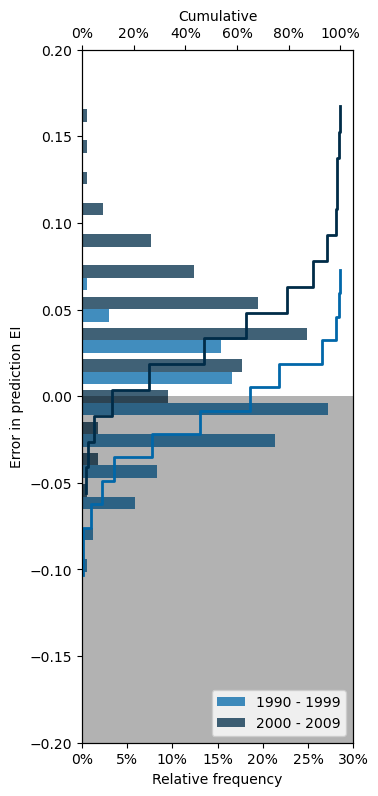

In [12]:
"Histogram EI deviations combined time periods (not overlapping) - ONE DECADE - cumulative"

import seaborn as sns
                          
fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(3.5)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
                            

for j in range(len(yrsl)):  
    EI_dev_total = []        
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            EI_dev_total.append(EI_dev)   
                
    EI_dev_grouped[j-1] = EI_dev_total
    w[j-1] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = yrsl[1:3]
c = colors[1:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev_grouped, bins=15, alpha = 0.75, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
plt.xlim(0,0.3)

plt.legend(loc='lower right')

ax2 = plt.gca().twiny()

for i in range(len(EI_dev_grouped)):
    sns.histplot(data=EI_dev_grouped[i], element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, color=c[i], y = EI_dev_grouped[i], linewidth = 2, linestyle='solid')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax2.grid('false')
ax2.set_xlabel('Cumulative')

# print(EI_dev_grouped)
ax2.grid(False)
ax2.set_facecolor("None")

plt.savefig(f'2_Output/{output}/Histograms/Histogram_timeslices1.png')   


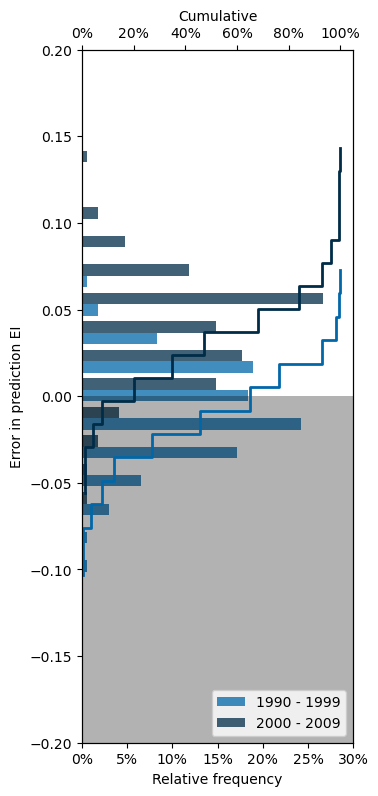

In [13]:
"Histogram EI deviations combined time periods (not overlapping) - PAST DECADE - cumulative"

import seaborn as sns
                          
fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(3.5)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
                            

for j in range(len(yrsl)):  
    EI_dev_total = []        
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation past decades {yrsl[j]}']].item()
            EI_dev_total.append(EI_dev)   
                
    EI_dev_grouped[j-1] = EI_dev_total
    w[j-1] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = yrsl[1:3]
c = colors[1:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev_grouped, bins=15, alpha = 0.75, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
plt.xlim(0,0.3)

plt.legend(loc='lower right')

ax2 = plt.gca().twiny()

for i in range(len(EI_dev_grouped)):
    sns.histplot(data=EI_dev_grouped[i], element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, color=c[i], y = EI_dev_grouped[i], linewidth = 2)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax2.grid('false')
ax2.set_xlabel('Cumulative')

# print(EI_dev_grouped)
ax2.grid(False)
ax2.set_facecolor("None")

plt.savefig(f'2_Output/{output}/Histograms/Histogram_timeslices1.png')   


### Histogram EI deviations grouped by aridity (not overlapping)

0 28 310


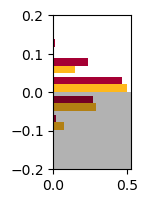

In [14]:
"Histogram EI deviations grouped by aridity (not overlapping)"

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]

                            
                
# print(catchment_list_AI)
for a in range(len(catchment_list_AI)):
    catchment_list = catchment_list_AI[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation past decades {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
# Label maken

des = 'AI'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_AI} (n={n1})", f"{cut1_AI} < {des} < {cut2_AI} (n={n2})", f"{des} > {cut2_AI} (n={n3})"]
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:3]
w = w[1:3]
labels = labels[1:3]
c = colors2[1:3]


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
# plt.ylabel('Error in prediction EI')
# plt.xlabel('Relative frequency')
# plt.legend(loc='lower right')
# plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


plt.savefig(f'2_Output/{output}/Histograms/Histogram_aridity_notoverlapping_v1.png')   

### Histogram EI deviations grouped by Seasonality Index (not overlapping)

85
69
15
170 138 30


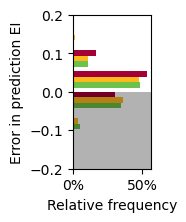

In [15]:
"Histogram EI deviations grouped by index (not overlapping)"

print(len(catchment_list_SI[0]))
print(len(catchment_list_SI[1]))
print(len(catchment_list_SI[2]))

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"SI < {cut1_SI}",
          f"{cut1_SI} <= SI < {cut2_SI}",
          f"{cut2_SI} <= SI"]

for a in range(len(catchment_list_SI)):
    catchment_list = catchment_list_SI[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
# Label maken

des = 'SI'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_SI} (n={n1})", f"{cut1_SI} < {des} < {cut2_SI} (n={n2})", f"{des} > {cut2_SI} (n={n3})"]
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors2[0:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_SI.png')   

### Histogram EI deviations grouped by Seasonality Timing (not overlapping)

(['01485500', '01486000', '02178400', '02212600', '02221525', '02342933', '02349900', '02395120', '02408540', '02422500', '02430085', '02430615', '02450250', '03285000', '03300400', '03384450', '03498500', '03504000', '03574500', '03604000', '07056000', '07057500', '07071500', '07261000', '07290650', '07346045', '07362100'], ['01411300', '01484100', '01487000', '01491000', '01580000', '01583500', '01591400', '01639500', '01669000', '02038850', '02046000', '02051000', '02051500', '02059500', '02064000', '02065500', '02081500', '02111180', '02111500', '02112120', '02118500', '02128000', '02143000', '02143040', '02149000', '02152100', '02177000', '03161000', '03439000', '03455500', '03456500', '07068000', '07196900', '07335700', '07340300'], ['01632900', '01638480', '01644000', '01658500', '01664000', '01666500', '01667500', '02013000', '02014000', '02017500', '02018000', '02027000', '02028500', '02053200', '02053800', '02055100', '02056900', '02069700', '02070000', '02074500', '02077200'

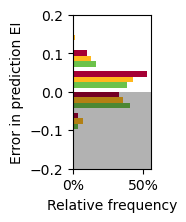

In [16]:
"Histogram EI deviations grouped by aridity (not overlapping)"


fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", "", "", ""]
w = ["", "", "", "", ""]
labels = [f"ST < {cut1_ST}",
          f"{cut1_ST} <= ST < {cut2_ST}",
          f"{cut2_ST} <= ST"]

print(catchment_list_ST)

print(len(catchment_list_ST[0]))
print(len(catchment_list_ST[1]))
print(len(catchment_list_ST[2]))


                
for a in range(len(catchment_list_ST)):
    catchment_list = catchment_list_ST[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
# Label maken

des = 'ST'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_ST} (n={n1})", f"{cut1_ST} < {des} < {cut2_ST} (n={n2})", f"{des} > {cut2_ST} (n={n3})"]                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors2[0:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_ST.png')   

### Histogram EI deviations grouped by Interstorm duration (not overlapping)

(['02013000', '02014000', '03140000', '03144000', '03159540', '03161000', '03164000', '03173000', '03213700', '03237280', '03237500', '03238500', '03281500', '03455500', '03460000', '03471500', '03473000', '03479000', '03488000', '03498500', '04196800'], ['01411300', '01484100', '01485500', '01486000', '01487000', '01491000', '01580000', '01583500', '01591400', '01632900', '01638480', '01639500', '01644000', '01658500', '01664000', '01666500', '01667500', '01669000', '02017500', '02018000', '02027000', '02028500', '02038850', '02046000', '02051000', '02051500', '02053200', '02053800', '02055100', '02056900', '02059500', '02064000', '02065500', '02069700', '02070000', '02074500', '02077200', '02081500', '02082950', '02102908', '02111180', '02111500', '02112120', '02112360', '02118500', '02125000', '02128000', '02143000', '02143040', '02149000', '02152100', '02177000', '02178400', '02202600', '02212600', '02221525', '02342933', '02349900', '02395120', '02408540', '02422500', '02430085', 

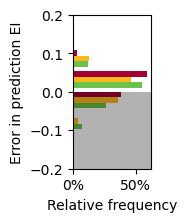

In [17]:
"Histogram EI deviations grouped by interstorm (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"Is_dur < {cut1_isdur}",
          f"{cut1_isdur} <= Is_dur < {cut2_isdur}",
          f"{cut2_isdur} <= Is_dur"]

print(catchment_list_isdur)



# Dit kan je weer hetzelfde laten (alleen bins aanpassen)

for a in range(len(catchment_list_isdur)):
    catchment_list = catchment_list_isdur[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
# Label maken

des = 'is_dur'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_isdur} (n={n1})", f"{cut1_isdur} < {des} < {cut2_isdur} (n={n2})", f"{des} > {cut2_isdur} (n={n3})"]                    
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors2[0:3]

# plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_isdur_notoverlapping_v1.png')   

print(len(catchment_list_isdur[0]))
print(len(catchment_list_isdur[1]))
print(len(catchment_list_isdur[2]))

### Histogram EI deviations grouped by Mean annual values (not overlapping)

(['07142300', '07299670', '07301500', '08082700', '08086212'], ['01411300', '01484100', '01485500', '01486000', '01487000', '01491000', '01580000', '01583500', '01591400', '01632900', '01638480', '01639500', '01644000', '01658500', '01664000', '01666500', '01667500', '01669000', '02013000', '02014000', '02017500', '02018000', '02027000', '02028500', '02038850', '02046000', '02051000', '02051500', '02053200', '02053800', '02055100', '02056900', '02059500', '02064000', '02065500', '02069700', '02070000', '02074500', '02077200', '02081500', '02082950', '02102908', '02111180', '02111500', '02112120', '02112360', '02118500', '02125000', '02128000', '02143000', '02149000', '02152100', '02202600', '02212600', '02221525', '02342933', '02349900', '02395120', '03140000', '03144000', '03159540', '03164000', '03165000', '03170000', '03173000', '03213700', '03237280', '03237500', '03238500', '03241500', '03281500', '03285000', '03291780', '03300400', '03340800', '03346000', '03357350', '03364500', 

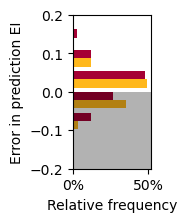

In [18]:
"Histogram EI deviations grouped by P (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"P < {cut1_Pa}",
          f"{cut1_Pa} <= P < {cut2_Pa}",
          f"{cut2_Pa} <= P"]

print(catchment_list_Pa)



# Dit kan je weer hetzelfde laten (alleen bins aanpassen)

for a in range(len(catchment_list_Pa)):
    catchment_list = catchment_list_Pa[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                

                
                
# Label maken

des = 'P'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_Pa} (n={n1})", f"{cut1_Pa} < {des} < {cut2_Pa} (n={n2})", f"{des} > {cut2_Pa} (n={n3})"]                          
                
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:3]
w = w[1:3]
labels = labels[1:3]
c = colors2[1:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_Pa_notoverlapping_v1.png')   

print(len(catchment_list_Pa[0]))
print(len(catchment_list_Pa[1]))
print(len(catchment_list_Pa[2]))

0
0
169
0 0 338
([], [], ['01411300', '01484100', '01485500', '01486000', '01487000', '01491000', '01580000', '01583500', '01591400', '01632900', '01638480', '01639500', '01644000', '01658500', '01664000', '01666500', '01667500', '01669000', '02013000', '02014000', '02017500', '02018000', '02027000', '02028500', '02038850', '02046000', '02051000', '02051500', '02053200', '02053800', '02055100', '02056900', '02059500', '02064000', '02065500', '02069700', '02070000', '02074500', '02077200', '02081500', '02082950', '02102908', '02111180', '02111500', '02112120', '02112360', '02118500', '02125000', '02128000', '02143000', '02143040', '02149000', '02152100', '02177000', '02178400', '02202600', '02212600', '02221525', '02342933', '02349900', '02395120', '02408540', '02422500', '02430085', '02430615', '02450250', '03140000', '03144000', '03159540', '03161000', '03164000', '03165000', '03170000', '03173000', '03213700', '03237280', '03237500', '03238500', '03241500', '03281500', '03285000', '0

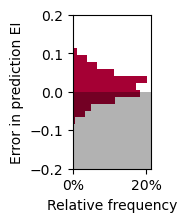

In [19]:
"Histogram EI deviations grouped by Ep (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"Ep < {cut1_Epa}",
          f"{cut1_Epa} <= Ep < {cut2_Epa}",
          f"{cut2_Epa} <= Ep"]

print(len(catchment_list_Epa[0]))
print(len(catchment_list_Epa[1]))
print(len(catchment_list_Epa[2]))

for a in range(len(catchment_list_Epa)):
    catchment_list = catchment_list_Epa[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
# Label maken

des = 'Ep'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_Epa} (n={n1})", f"{cut1_Epa} < {des} < {cut2_Epa} (n={n2})", f"{des} > {cut2_Epa} (n={n3})"]                     
                
# Hier invullen welke niet arrays niet leeg zijn
print(catchment_list_Epa)
EI_dev_grouped = EI_dev_grouped[2:3]
w = w[2:3]
labels = labels[2:3]
c = colors2[2:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_Ep_notoverlapping_v1.png')   



4 282 52
(['03455500', '03460000'], ['01411300', '01484100', '01485500', '01486000', '01487000', '01491000', '01580000', '01583500', '01591400', '01632900', '01638480', '01639500', '01644000', '01658500', '01664000', '01666500', '01667500', '01669000', '02013000', '02014000', '02017500', '02018000', '02027000', '02028500', '02038850', '02046000', '02051000', '02051500', '02053800', '02055100', '02056900', '02059500', '02064000', '02065500', '02069700', '02070000', '02074500', '02077200', '02081500', '02082950', '02111180', '02111500', '02112120', '02112360', '02118500', '02143000', '02143040', '02149000', '02152100', '02177000', '02178400', '03140000', '03144000', '03159540', '03161000', '03164000', '03165000', '03170000', '03173000', '03213700', '03237280', '03237500', '03238500', '03241500', '03281500', '03285000', '03291780', '03300400', '03340800', '03346000', '03357350', '03364500', '03366500', '03368000', '03384450', '03439000', '03456500', '03471500', '03473000', '03479000', '03

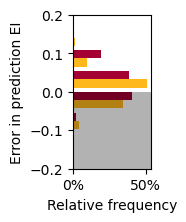

In [20]:
"Histogram EI deviations grouped by T (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"T < {cut1_T}",
          f"{cut1_T} <= T < {cut2_T}",
          f"{cut2_T} <= T"]

for a in range(len(catchment_list_T)):
    catchment_list = catchment_list_T[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
# Label maken

des = 'T'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_T} (n={n1})", f"{cut1_T} < {des} < {cut2_T} (n={n2})", f"{des} > {cut2_T} (n={n3})"]                    
                
# Hier invullen welke niet arrays niet leeg zijn
print(catchment_list_T)
EI_dev_grouped = EI_dev_grouped[1:3]
w = w[1:3]
labels = labels[1:3]
c = colors2[1:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_T_notoverlapping_v1.png')   

print(len(catchment_list_T[0]))
print(len(catchment_list_T[1]))
print(len(catchment_list_T[2]))

## Change vs Change

### Aridity

98 166 74
-0.22314341921769998
0.25674725288135236


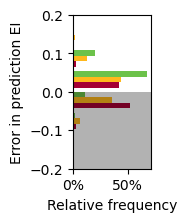

In [21]:
" Change vs change: aridity"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_USA
    

change1 = -0.05
change2 = 0.05    
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []


w = ["", "", ""]
labels = ["AI decreases", "AI stable (change between -0.05 and 0.05)", "AI increases"]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'AI_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"ΔAI < {change1} (n={n1})", f"{change1} < ΔAI < {change2} (n={n2})", f"ΔAI > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Precipitation

118 52 168
-377.82477777777785
275.4553333333329


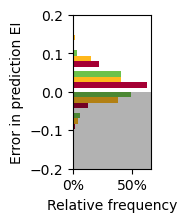

In [22]:
" Change vs change: precipitation"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_USA
    

change1 = -20
change2 = 20
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'Pa'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Evaporation

103 186 49
-44.099001104049535
34.18529343115813


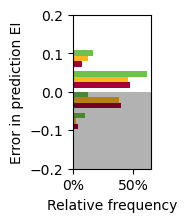

In [23]:
" Change vs change: evaporation"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_USA
    

change1 = -10
change2 = 10
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'Epa'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Temperature

18 205 115
-0.4816090070379371
0.9045672420937798


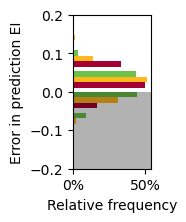

In [24]:
" Change vs change: temperature"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_USA
    

change1 = -0.2
change2 = 0.2
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'T'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Interstorm duration

151 47 140
-1.1891303756494302
1.4625601859538433


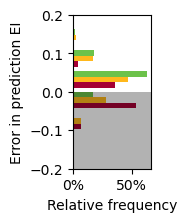

In [25]:
" Change vs change: Interstorm duration"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_USA
    

change1 = -0.1
change2 = 0.1
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'is_dur'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Seasonality index

99 116 123
-0.2739885471882647
0.154863491666386


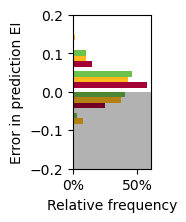

In [26]:
" Change vs change: Seasonality index"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_USA
    

change1 = -0.02
change2 = 0.02
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'SI'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/SI_change.png')   

## Seasonality timing

122 46 170
-0.3085419807409513
0.38270957367712255


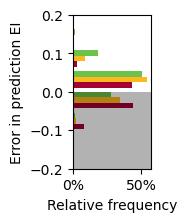

In [27]:
" Change vs change: Seasonality timing"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_USA
    

change1 = -0.02
change2 = 0.02
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'ST'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=5, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/ST_change.png')   

# Archive

## Plot correlations (Archive)

In [23]:
for k in range(len(descriptors)):
    plt.suptitle('CAMELS GB')
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(5)
    fig.set_figwidth(7)
    
    EI_dev_total = []
    des_change_total = []
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                            
                plt.plot(df_output[f'{descriptors[k]}_change {yr}'], df_output[f'EI deviation {yrsl[j]}'], '.', c=colors[j])      

    x = des_change_total
    y = EI_dev_total
    
    pearson = pearsonr(x, y)
    m, b = np.polyfit(x, y, 1)
    pearsony = np.zeros(len(x))
    
    for q in range(len(EI_dev_total)):
        pearsony[q] = m * x[q] + b
    axs.plot(x, pearsony, 'k')
                
        
    axs.set_xlabel(f"Change in {descriptors_names[k]}")
    axs.set_ylabel(f"Devation Evaporative Index")
    axs.set_title(f"CAMELS USA {descriptors_names[k]}")
    
    
    legend = [Line2D([0], [0], marker='.', color='gainsboro', label=f'{yrsl[1]}',
                       markerfacecolor=f'{colors[1]}', markersize=15),
              Line2D([0], [0], marker='.', color='gainsboro', label=f'{yrsl[2]}',
                       markerfacecolor=f'{colors[2]}', markersize=15),
             Line2D([0], [0], color='k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" ,
                       markerfacecolor='k', markersize=10)]                    

    axs.legend(handles=legend,loc='lower right')
                
    plt.savefig(f'2_Output/{output}/Results/Change_total_time_{descriptors_names[k]}.png')   
    plt.close()

<Figure size 640x480 with 0 Axes>

### Plot correlations for seperate time periods

In [ ]:
for i in range(len(descriptors)):
    n_tot = len(yrsl) - 1 
    fig, axs = plt.subplots(1, n_tot)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    plt.suptitle('CAMELS GB')
    for j in range(len(yrsl)):
        if j > 0:
            yr = yrsl[j]
            c = colors[j]
            n = j - 1
            
            for c in range(len(df_output)):
                axs[n].plot(df_output[f'{descriptors[i]}_change {yr}'], df_output[f'EI deviation {yr}'], '.')      

            x = df_output[f'{descriptors[i]}_change {yr}']
            y = df_output[f'EI deviation {yr}']

                
            pearson = pearsonr(x, y)

            m, b = np.polyfit(x, y, 1)
            axs[n].plot(x, m*x + b, 'k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" )
            axs[n].legend(loc='lower right')
                
                
            axs[n].set_xlabel(f"Change in {descriptors_names[i]}")
            axs[n].set_ylabel(f"Devation Evaporation Index")
            axs[n].set_title(f"Change in {descriptors_names[i]} period of {yr}")
    plt.savefig(f'2_Output/{output}/Results/Change_{descriptors_names[i]}.png')   
    plt.close(fig)

## Plot EI expected (Archive)

In [ ]:
catchment_list = catchment_list_USA

for i in range(len(catchment_list)): 
    # print(catchment_list[i])
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
        
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    
    data = data.loc["1981-01-01":"2008-12-31"]
    data = data.sort_index(ascending=True)
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()

    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
        
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')
    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    data['year'] = pd.DatetimeIndex(data['date']).year  
    
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['YR']) & (data['YR'] < yrcut[j+1])]      
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']].item()
        EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_Mak_knmi'].mean()    
        T = datanew['TAIR'].mean()
        P  = datanew['PRCP'].mean()
        Q  = datanew['OBS_RUN'].mean()
        
        axs[0].plot(AI, EI, marker='o', color=c,markersize=5)
    
                            
        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out, color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='.', color=c, markersize=10)
        
        if j > 0:
            c_exp = colors[j-1]
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            axs[0].plot(AI, EI_exp, marker='d', color=c, markersize=5)
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['PRCP']
        EP_ts = datanew['Ep_Mak_knmi']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
    legend_0 = [Line2D([0], [0], marker='d', color='lightgrey', label='Expected value EI',
                       markerfacecolor='k', markersize=10),
                Line2D([0], [0], marker='.', color='lightgrey', label='Actual value EI',
                       markerfacecolor='k', markersize=15)]
    
    legend_1 = [Line2D([0], [0], color=colors[0], lw=1, label=f'{yrsl[0]}'),
                Line2D([0], [0], color=colors[1], lw=1, label=f'{yrsl[1]}'),
                Line2D([0], [0], color=colors[2], lw=1, label=f'{yrsl[2]}')]
                       

    axs[0].legend(handles=legend_0,loc='lower right')
    axs[1].legend(handles=legend_1,loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments2/Expected_Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)
    
    
print("end loop")

In [ ]:
catchment_list = catchment_list_USA

for i in range(len(catchment_list)): 
    # print(catchment_list[i])
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
        
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    
    data = data.loc["1981-01-01":"2008-12-31"]
    data = data.sort_index(ascending=True)
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()

    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
        
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')
    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    data['year'] = pd.DatetimeIndex(data['date']).year  
    
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['YR']) & (data['YR'] < yrcut[j+1])]      
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']].item()
        EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_Mak_knmi'].mean()    
        T = datanew['TAIR'].mean()
        P  = datanew['PRCP'].mean()
        Q  = datanew['OBS_RUN'].mean()
        
        axs[0].plot(AI, EI, marker='o', color=c,markersize=5)
    
                            
        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out, color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='.', color=c, markersize=10)
        
        if j > 0:
            c_exp = colors[j-1]
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            axs[0].plot(AI, EI_exp, marker='d', color=c, markersize=5)
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['PRCP']
        EP_ts = datanew['Ep_Mak_knmi']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
    legend_0 = [Line2D([0], [0], marker='d', color='lightgrey', label='Expected value EI',
                       markerfacecolor='k', markersize=10),
                Line2D([0], [0], marker='.', color='lightgrey', label='Actual value EI',
                       markerfacecolor='k', markersize=15)]
    
    legend_1 = [Line2D([0], [0], color=colors[0], lw=1, label=f'{yrsl[0]}'),
                Line2D([0], [0], color=colors[1], lw=1, label=f'{yrsl[1]}'),
                Line2D([0], [0], color=colors[2], lw=1, label=f'{yrsl[2]}')]
                       

    axs[0].legend(handles=legend_0,loc='lower right')
    axs[1].legend(handles=legend_1,loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments2/Expected_Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)
    
    
print("end loop")

## Plot Budyko (Archive)

In [ ]:
catchment_list = catchment_list_USA
plt.figure(figsize=(10,5)).suptitle("CAMELS USA (n=130)",fontsize=20)

for i in range(len(catchment_list)):     
    # Import data and select the right dates
    data = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_modelOutput_daymet/model_output_daymet/model_output/flow_timeseries/daymet/All_folders/'+str(catchment_list[i])+str('_05_model_output.txt'), delimiter=' ', skipinitialspace=True)
    data['date'] = pd.to_datetime(data['YR'].astype('str')+
                                 data['MNTH'].astype('str')+
                                 data['DY'].astype('str'),
                           format='%Y%m%d')
    daymet = pd.read_csv('1_Data/CamelsUSA3/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/maurer_en_nldas/maurer/all_folders/'+str(catchment_list[i])+str('_lump_maurer_forcing_leap.txt'), sep='[ ,\t]', parse_dates=[0,1,2], skiprows=3, skipinitialspace=True, engine='python')
    daymet.loc[:,'dt'] = pd.to_datetime(daymet['Year'].dt.year.astype('str')+
                                 daymet['Mnth'].astype('str')+
                                 daymet['Day'].astype('str'),
                           format='%Y%m%d')
    
    daymet.index       = daymet['dt']
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    
    daymet = daymet.loc["1981-01-01":"2008-12-31"]
    data = data.loc["1981-01-01":"2008-12-31"]
        
    if np.size(daymet) !=122724:
        continue
    if np.size(data) !=143178:
        continue
           
    # Compute the Makkink potential evaporation
    temp         = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    rad_knmi     = daymet['SRAD(W/m2)'] * daymet['Dayl(s)']

    Eref_knmi  = calc_Makkink_knmi_USA(temp, rad_knmi)
    data['Ep_Mak_knmi'] = Eref_knmi * 1000
    daymet['Temperature'] = (daymet['Tmax(C)'] + daymet['Tmin(C)']) / 2
    
    # Compute mean values
    Ep  = data['Ep_Mak_knmi'].mean()
    P = data['PRCP'].mean() 
    T = data['TAIR'].mean()
    Q = data['OBS_RUN'].mean()

    # Compute Ea, AI, EI
    Ea = P - Q
    EI = Ea / P
    AI = Ep / P
    
    # Plot every catchment
    if Ea > 0 and AI > EI: 
        budyko_curve_x = np.arange(1, 3, 0.05)
        energy_limit_x = np.arange(0, 1.0001, 0.05)
        x = np.arange(0, 1.0001, 0.05)
        water_limit_y = 1 + budyko_curve_x*0
        energy_limit_y = energy_limit_x
        y = 1 + x*0
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.minorticks_on()
        plt.plot(energy_limit_x, energy_limit_y, c='k')
        plt.plot(budyko_curve_x, water_limit_y,c='k')
        
        plt.plot(AI, EI, marker='.', c = 'b')

        
plt.savefig(f'2_Output/{output}/Budyko.png')   
plt.close()